# Model Card Enrichment
Objective: Fetch and parse HuggingFace model cards to enrich metadata with descriptions, use cases, and limitations.
Outputs:

data/processed/hf_models_enriched.parquet
data/cache/model_cards/*.md (cached README files)

## 1. Setup & Load Raw Data

In [6]:
# Setup & Load Raw Data
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Add colab_src to path
BASE_DIR = Path("/content/drive/MyDrive/llm-recommender-colab")
sys.path.insert(0, str(BASE_DIR / "colab_src"))

from utils import PathManager, save_json, validate_dataframe
from card_parser import ModelCardFetcher, ModelCardParser

# Initialize paths
paths = PathManager(BASE_DIR)

# Load raw metadata from Sprint 1
raw_file = paths.RAW_DIR / "hf_models_raw.parquet"
df_raw = pd.read_parquet(raw_file)

print(f"✅ Loaded {len(df_raw)} models from Sprint 1")
print(f"   Columns: {list(df_raw.columns)}")


✅ Loaded 95 models from Sprint 1
   Columns: ['model_id', 'author', 'downloads', 'likes', 'tags', 'pipeline_tag', 'library_name', 'created_at', 'last_modified', 'private', 'gated', 'model_type', 'license']


## 2. Initialize Card Fetcher

In [7]:
# Initialize Card Fetcher
# Create cache directory for model cards
card_cache_dir = paths.CACHE_DIR / "model_cards"
card_cache_dir.mkdir(parents=True, exist_ok=True)

# Initialize fetcher
fetcher = ModelCardFetcher(
    cache_dir=card_cache_dir,
    rate_limit_delay=0.3  # 300ms between requests
)

print(f"✅ Card fetcher initialized")
print(f"   Cache directory: {card_cache_dir}")

✅ Card fetcher initialized
   Cache directory: /content/drive/MyDrive/llm-recommender-colab/data/cache/model_cards


## 3. Fetch Model Cards (Batched)
Note: This will take ~5-10 minutes for 100 models with rate limiting.

In [8]:
# Fetch Model Cards (Batched)
# Get list of model IDs
model_ids = df_raw['model_id'].tolist()

print(f"Fetching model cards for {len(model_ids)} models...")
print(f"⏱️  Estimated time: ~{len(model_ids) * 0.3 / 60:.1f} minutes")
print()

# Fetch all cards
card_texts = fetcher.fetch_batch(
    model_ids=model_ids,
    use_cache=True,
    show_progress=True
)

# Count successful fetches
successful = sum(1 for text in card_texts.values() if text)
print(f"\n✅ Successfully fetched {successful}/{len(model_ids)} model cards")
print(f"   Missing cards: {len(model_ids) - successful}")

Fetching model cards for 95 models...
⏱️  Estimated time: ~0.5 minutes



Fetching model cards:   0%|          | 0/95 [00:00<?, ?it/s]


✅ Successfully fetched 94/95 model cards
   Missing cards: 1


## 4. Parse Model Cards
Extract structured information from raw card text.

In [13]:
# Parse Model Cards (ENHANCED - Fixed)
print("Parsing model cards with enhanced extraction...")

parsed_cards = []

for idx, row in df_raw.iterrows():
    model_id = row['model_id']
    card_text = card_texts.get(model_id)

    # Safely extract and convert tags to list
    tags = row.get('tags', [])
    if tags is None:
        tags = []
    elif not isinstance(tags, list):
        try:
            tags = list(tags)
        except:
            tags = []

    # Ensure card_text is string or None
    if card_text is not None and not isinstance(card_text, str):
        try:
            card_text = str(card_text)
        except:
            card_text = None

    # Parse with enhanced parser
    parsed = ModelCardParser.parse_full_card(model_id, card_text, tags)

    # Convert to dictionary
    parsed_cards.append({
        'model_id': parsed.model_id,
        'card_description': parsed.description,
        'card_use_cases': parsed.use_cases,
        'card_limitations': parsed.limitations,
        'card_training': parsed.training_details,
        'card_length': parsed.card_length,
        'has_yaml': parsed.has_yaml,
        'yaml_language': parsed.yaml_metadata.get('language'),
        'yaml_license': parsed.yaml_metadata.get('license'),
        'yaml_datasets': str(parsed.yaml_metadata.get('datasets')) if parsed.yaml_metadata.get('datasets') else None,
        # NEW: Cost proxy fields
        'num_parameters': parsed.num_parameters,
        'quantization': parsed.quantization,
        'model_size_category': parsed.model_size_category,
    })

df_cards = pd.DataFrame(parsed_cards)

print(f"✅ Parsed {len(df_cards)} model cards")
print(f"\nCard data columns: {list(df_cards.columns)}")

# Show parameter extraction stats
param_count = df_cards['num_parameters'].notna().sum()
quant_count = df_cards['quantization'].notna().sum()

print(f"\n{'='*60}")
print("COST PROXY EXTRACTION")
print(f"{'='*60}")
print(f"Models with parameter counts: {param_count}/{len(df_cards)} ({param_count/len(df_cards)*100:.1f}%)")
print(f"Models with quantization info: {quant_count}/{len(df_cards)} ({quant_count/len(df_cards)*100:.1f}%)")

# Show size distribution
if param_count > 0:
    print(f"\nModel Size Distribution:")
    print(df_cards['model_size_category'].value_counts())

    print(f"\nParameter Count Examples:")
    param_examples = df_cards[df_cards['num_parameters'].notna()][['model_id', 'num_parameters', 'model_size_category']].head(10)
    for _, row in param_examples.iterrows():
        print(f"  {row['model_id']:40s} → {row['num_parameters']:5.1f}B ({row['model_size_category']})")

if quant_count > 0:
    print(f"\nQuantization Types:")
    print(df_cards['quantization'].value_counts())

Parsing model cards with enhanced extraction...
✅ Parsed 95 model cards

Card data columns: ['model_id', 'card_description', 'card_use_cases', 'card_limitations', 'card_training', 'card_length', 'has_yaml', 'yaml_language', 'yaml_license', 'yaml_datasets', 'num_parameters', 'quantization', 'model_size_category']

COST PROXY EXTRACTION
Models with parameter counts: 86/95 (90.5%)
Models with quantization info: 32/95 (33.7%)

Model Size Distribution:
model_size_category
medium    31
xlarge    24
small     16
tiny       8
large      7
Name: count, dtype: int64

Parameter Count Examples:
  openai-community/gpt2                    →   5.0B (medium)
  Qwen/Qwen2.5-3B-Instruct                 →   3.0B (medium)
  openai/gpt-oss-20b                       →  20.0B (large)
  Qwen/Qwen2.5-7B-Instruct                 →   7.0B (medium)
  Qwen/Qwen3-0.6B                          →   0.6B (tiny)
  Qwen/Qwen3-4B-Instruct-2507              →   4.0B (medium)
  Qwen/Qwen2.5-1.5B-Instruct               →   

## 5. Create Enriched Dataset
Merge parsed card data with original metadata.

In [14]:
# Create Enriched Dataset
# Merge with original metadata
df_enriched = df_raw.merge(df_cards, on='model_id', how='left')

print(f"✅ Created enriched dataset")
print(f"   Shape: {df_enriched.shape}")
print(f"   Columns: {len(df_enriched.columns)}")

# Show sample
display(df_enriched[['model_id', 'author', 'downloads', 'card_description']].head())



✅ Created enriched dataset
   Shape: (95, 25)
   Columns: 25


,model_id,author,downloads,card_description
0,openai-community/gpt2,openai-community,9452248,Test the whole generation capabilities here: P...
1,Qwen/Qwen2.5-3B-Instruct,Qwen,7871619,None
2,openai/gpt-oss-20b,openai,7632636,Try gpt-oss · Guides · Model card · OpenAI blo...
3,Qwen/Qwen2.5-7B-Instruct,Qwen,7530449,None
4,Qwen/Qwen3-0.6B,Qwen,7068572,None


## 6. Data Quality Analysis
Analyze completeness of enriched fields.

ENRICHMENT QUALITY REPORT
card_description         :  41/95 ( 43.2%)
card_use_cases           :  17/95 ( 17.9%)
card_limitations         :   7/95 (  7.4%)
card_training            :  30/95 ( 31.6%)
has_yaml                 :  95/95 (100.0%)


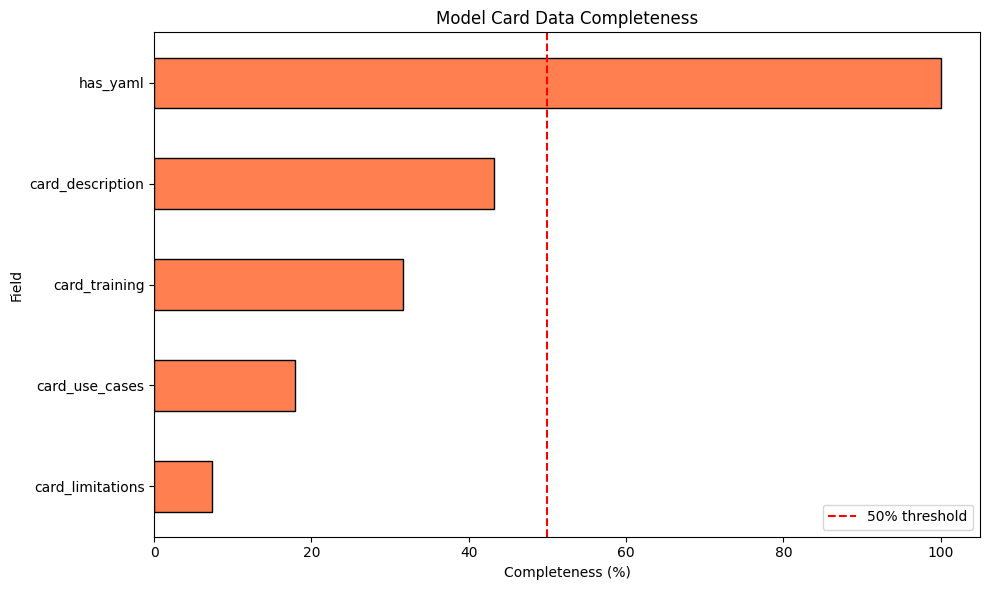

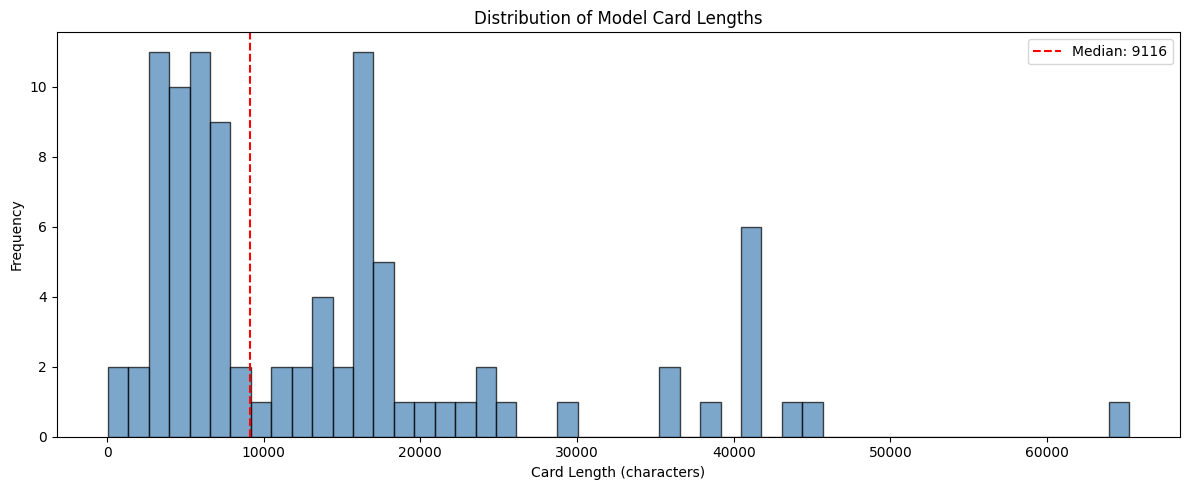

In [15]:
 # Data Quality Analysis
# Analyze completeness of enriched fields
enrichment_fields = [
    'card_description', 'card_use_cases', 'card_limitations',
    'card_training', 'has_yaml'
]

print("="*60)
print("ENRICHMENT QUALITY REPORT")
print("="*60)

for field in enrichment_fields:
    non_null = df_enriched[field].notna().sum()
    pct = (non_null / len(df_enriched)) * 100
    print(f"{field:25s}: {non_null:3d}/{len(df_enriched)} ({pct:5.1f}%)")

# Visualize completeness
completeness_enrich = (df_enriched[enrichment_fields].notna().sum() / len(df_enriched)) * 100

plt.figure(figsize=(10, 6))
completeness_enrich.sort_values().plot(kind='barh', color='coral', edgecolor='black')
plt.xlabel('Completeness (%)')
plt.ylabel('Field')
plt.title('Model Card Data Completeness')
plt.axvline(x=50, color='red', linestyle='--', label='50% threshold')
plt.legend()
plt.tight_layout()
plt.show()

# Card length distribution
plt.figure(figsize=(12, 5))
card_lengths = df_enriched[df_enriched['card_length'] > 0]['card_length']

if len(card_lengths) > 0:
    plt.hist(card_lengths, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    plt.xlabel('Card Length (characters)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Model Card Lengths')
    plt.axvline(card_lengths.median(), color='red', linestyle='--',
                label=f'Median: {card_lengths.median():.0f}')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  No card length data available")



## 7. Sample Enriched Entries
View examples of enriched model information.

In [16]:
# Sample Enriched Entries
print("="*60)
print("SAMPLE ENRICHED ENTRIES")
print("="*60)

# Show 3 models with complete card data
complete_cards = df_enriched[df_enriched['card_description'].notna()]

if len(complete_cards) > 0:
    for idx, row in complete_cards.head(3).iterrows():
        print(f"\n{'='*60}")
        print(f"Model: {row['model_id']}")
        print(f"Author: {row['author']}")
        print(f"Downloads: {row['downloads']:,}")
        print(f"Likes: {row['likes']:,}")
        print(f"\nDescription:")
        print(f"  {row['card_description'][:200]}...")

        if row['card_limitations']:
            print(f"\nLimitations:")
            print(f"  {row['card_limitations'][:150]}...")
else:
    print("⚠️  No models with card descriptions found")

SAMPLE ENRICHED ENTRIES

Model: openai-community/gpt2
Author: openai-community
Downloads: 9,452,248
Likes: 3,042

Description:
  Test the whole generation capabilities here: Pretrained model on English language using a causal language modeling (CLM) objective. It was introduced in this paper and first released at this page. Dis...

Model: openai/gpt-oss-20b
Author: openai
Downloads: 7,632,636
Likes: 4,017

Description:
  Try gpt-oss · Guides · Model card · OpenAI blog Welcome to the gpt-oss series, OpenAI’s open-weight models designed for powerful reasoning, agentic tasks, and versatile developer use cases. We’re rele...

Model: meta-llama/Llama-3.1-8B-Instruct
Author: meta-llama
Downloads: 4,991,933
Likes: 5,068

Description:
  ## Model Information The Meta Llama 3.1 collection of multilingual large language models (LLMs) is a collection of pretrained and instruction tuned generative models in 8B, 70B and 405B sizes (text in...


## 8. Save Enriched Dataset

In [18]:
# Save Enriched Dataset (FIXED)

# Convert list columns to strings for Parquet compatibility
print("Preparing data for Parquet export...")

# Create a copy to avoid modifying original
df_export = df_enriched.copy()

# Convert list/array columns to strings
list_columns = ['tags', 'yaml_language', 'yaml_datasets']

for col in list_columns:
    if col in df_export.columns:
        df_export[col] = df_export[col].apply(
            lambda x: str(x) if x is not None and not isinstance(x, str) else x
        )

# Save enriched dataset
enriched_file = paths.PROCESSED_DIR / "hf_models_enriched.parquet"
df_export.to_parquet(enriched_file, index=False)

print(f"✅ Saved enriched dataset to: {enriched_file}")
print(f"   File size: {enriched_file.stat().st_size / 1024:.2f} KB")
print(f"   Total rows: {len(df_export)}")
print(f"   Total columns: {len(df_export.columns)}")

# Save enrichment summary
card_lengths = df_enriched[df_enriched['card_length'] > 0]['card_length']

enrichment_fields = [
    'card_description', 'card_use_cases', 'card_limitations',
    'card_training', 'has_yaml'
]

enrichment_summary = {
    'metadata': {
        'created_at': pd.Timestamp.now().isoformat(),
        'total_models': len(df_enriched),
        'models_with_cards': int(df_enriched['card_length'].gt(0).sum())
    },
    'completeness': {
        field: float((df_enriched[field].notna().sum() / len(df_enriched)) * 100)
        for field in enrichment_fields
    },
    'cost_proxies': {
        'models_with_parameters': int(df_enriched['num_parameters'].notna().sum()),
        'models_with_quantization': int(df_enriched['quantization'].notna().sum()),
        'parameter_coverage_pct': float((df_enriched['num_parameters'].notna().sum() / len(df_enriched)) * 100),
        'quantization_coverage_pct': float((df_enriched['quantization'].notna().sum() / len(df_enriched)) * 100),
    },
    'statistics': {
        'median_card_length': int(card_lengths.median()) if len(card_lengths) > 0 else 0,
        'mean_card_length': int(card_lengths.mean()) if len(card_lengths) > 0 else 0,
        'models_with_yaml': int(df_enriched['has_yaml'].sum()),
        'mean_parameters': float(df_enriched['num_parameters'].mean()) if df_enriched['num_parameters'].notna().sum() > 0 else 0,
    }
}

summary_file = paths.PROCESSED_DIR / "enrichment_summary.json"
save_json(enrichment_summary, summary_file)

print(f"\n✅ Summary saved to: {summary_file}")
print(f"\n{'='*60}")
print("SPRINT 2 COMPLETE")
print(f"{'='*60}")
print(f"✅ Enriched data: {enriched_file}")
print(f"✅ Card cache: {paths.CACHE_DIR / 'model_cards'}")
print(f"✅ Summary: {summary_file}")

# Print key statistics
print(f"\n📊 Key Statistics:")
print(f"   Models with parameter counts: {enrichment_summary['cost_proxies']['models_with_parameters']} ({enrichment_summary['cost_proxies']['parameter_coverage_pct']:.1f}%)")
print(f"   Models with quantization: {enrichment_summary['cost_proxies']['models_with_quantization']} ({enrichment_summary['cost_proxies']['quantization_coverage_pct']:.1f}%)")
print(f"   Mean parameters: {enrichment_summary['statistics']['mean_parameters']:.2f}B")
print(f"   Card description coverage: {enrichment_summary['completeness']['card_description']:.1f}%")



Preparing data for Parquet export...
✅ Saved enriched dataset to: /content/drive/MyDrive/llm-recommender-colab/data/processed/hf_models_enriched.parquet
   File size: 46.94 KB
   Total rows: 95
   Total columns: 25

✅ Summary saved to: /content/drive/MyDrive/llm-recommender-colab/data/processed/enrichment_summary.json

SPRINT 2 COMPLETE
✅ Enriched data: /content/drive/MyDrive/llm-recommender-colab/data/processed/hf_models_enriched.parquet
✅ Card cache: /content/drive/MyDrive/llm-recommender-colab/data/cache/model_cards
✅ Summary: /content/drive/MyDrive/llm-recommender-colab/data/processed/enrichment_summary.json

📊 Key Statistics:
   Models with parameter counts: 86 (90.5%)
   Models with quantization: 32 (33.7%)
   Mean parameters: 26.68B
   Card description coverage: 43.2%

Next: Sprint 3 - Feature Engineering & Embeddings
